In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch', 'transformers', 'joblib', 'calamanCy', 'accelerate'])
except ImportError:
    pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
import numpy as np
import pandas as pd

In [ ]:
from sklearn.pipeline import Pipeline
from transformers import BertForSequenceClassification
from torch import nn, device, cuda, optim
from skorch import NeuralNetClassifier
from skorch.hf import HuggingfacePretrainedTokenizer
from skorch.callbacks import Checkpoint, LoadInitState, ProgressBar

_device = device("cuda" if cuda.is_available() else "cpu")
"""
Set the device used by the learner.
It automatically uses the GPU if it is available, else,
it will default to the CPU.
Using the GPU is preferred because it is faster,
and can handle greater quantities of data.
"""

_model_name = "bert-base-multilingual-uncased"
"""
mBERT on Huggingface
"""

_model = BertForSequenceClassification.from_pretrained(
    _model_name,
    device_map=_device,
)
_model.to(_device)
"""
Make the mBERT model and map it to the device.
This automatically downloads it from Huggingface if it is
not already on the current system.
"""

class BertModel(nn.Module):
    """
    Custom Pytorch module for mBERT.
    This simply gets the output from mBERT and returns the
    logits, allowing it to properly classify inputs.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bert = _model

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        return x.logits

BertTokenizer = HuggingfacePretrainedTokenizer('bert-base-multilingual-uncased')
"""
Load the tokenizer for use in mBERT.
It is the tokenizer made specifically for use in mBERT,
and as such, should be utilized here to process text input.
"""

Criterion = nn.CrossEntropyLoss
"""
Loss function for multilabel classification. This is desired
so we get the right output shape to be uniform with the other
learners.
This was chosen over BCELoss because BCELoss does not have the
right output shape.
"""

Optimizer = optim.Adam
"""
Implements the Adam algorithm as the optimizer,
commonly used in text classification problems.
"""

checkpoint = Checkpoint(
    monitor='train_loss_best',
    dirname='train_bert',
    load_best=True,
)
"""
Checkpoint is used to save and load training progress.
"""

load_state = LoadInitState(checkpoint)
"""
Create a callback that loads the checkpoint.
"""

progress_bar = ProgressBar()

BertNet = NeuralNetClassifier(
    BertModel,
    criterion=Criterion,
    optimizer=Optimizer,
    device=_device,
    callbacks=[
        checkpoint,
        load_state,
        progress_bar,
    ],
    train_split=None, # Fixes numpy.exceptions.AxisError in training
                      # Anyways, data is assumed to be already split
)
"""
Define the mBERT neural network alongside parameters of it,
its optimizer, and its criterion.
"""

BertPipeline = Pipeline([
    ('tokenizer', BertTokenizer),
    ('bert', BertNet),
])
"""
Pipeline for mBERT. Import this for the ensemble.
"""

BertPipeline.set_params(
    tokenizer__max_length=255,
)
"""
Setting parameters of the tokenizer in the mBERT pipeline
so that the output shape is processable by the ensemble.
"""

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\nSetting parameters of the tokenizer in the mBERT pipeline\nso that the output shape is processable by the ensemble.\n'

In [ ]:
def load_model(model_name: str):
  try:
    return joblib.load(model_name)
  except FileNotFoundError:
    print("ERROR: Model not found")
    return None

learner_bayes = load_model('/content/drive/MyDrive/School/Thesis - Hate Speech/Models/For 100%/Bayes.pkl')
learner_lstm = load_model('/content/drive/MyDrive/School/Thesis - Hate Speech/Models/For 100%/LSTM.pkl')
learner_bert = load_model('/content/drive/MyDrive/School/Thesis - Hate Speech/Models/For 100%/mBERT.pkl')
learner_lr = load_model('/content/drive/MyDrive/School/Thesis - Hate Speech/Models/For 100%/LR.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BernoulliNB from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info 

ℹ Installing 'tl_calamancy_md-0.1.0' from
https://huggingface.co/ljvmiranda921/tl_calamancy_md/resolve/main/tl_calamancy_md-any-py3-none-any.whl...


/usr/local/lib/python3.10/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
learner_bayes

Pipeline(steps=[('tfidf', CountVectorizer()),
                ('bayes', BernoulliNB(alpha=0.3))])

In [ ]:
learner_lstm

Pipeline(steps=[('tokenizer', CalamancyTokenizer()),
                ('lstm',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LstmModel(
    (lstm): LSTM(200, 300, batch_first=True)
    (fc): Linear(in_features=300, out_features=2, bias=True)
  ),
))])

In [ ]:
learner_bert

Pipeline(steps=[('tokenizer',
                 HuggingfacePretrainedTokenizer(max_length=255,
                                                tokenizer='bert-base-multilingual-uncased')),
                ('bert',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BertModel(
    (bert): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(105879, 768, padding_idx=0)
          (position...
                (dense): Linear(in_features=3072, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
        (pooler): BertPooler(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (activation): Tanh()
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (classifier): Linear(in_features=768, out_features=2, bias=True)
    )
  ),
))])

In [ ]:
learner_lr

LogisticRegression(C=0.1)

In [ ]:
def concatenate_predict(inputs: list):
  with torch.inference_mode():
    bayes_pred = learner_bayes.predict(inputs)
    lstm_pred = learner_lstm.predict(inputs)
    bert_pred = learner_bert.predict(inputs)

  return np.array([
      bayes_pred,
      lstm_pred,
      bert_pred,
  ])

In [ ]:
def concatenate_predict_proba(inputs: list):
  with torch.inference_mode():
    bayes_pred = learner_bayes.predict_proba(inputs)
    lstm_pred = learner_lstm.predict_proba(inputs)
    bert_pred = learner_bert.predict_proba(inputs)

  return np.array([
      bayes_pred,
      lstm_pred,
      bert_pred,
  ])

In [ ]:
def hard_voting(inputs: list):
  preds = concatenate_predict(inputs)
  results = np.apply_along_axis(
      lambda x: np.bincount(x).argmax(),
      axis=0,
      arr=preds
  )
  return results

In [ ]:
def soft_voting(inputs: list):
  preds = concatenate_predict_proba(inputs)
  results = np.average(
      preds, axis=0,
  )
  return results

In [ ]:
def stacking(inputs: list):
  preds = concatenate_predict_proba(inputs)

  # Get only the predictions for hate speech
  # Since logistic regression is implemented
  # to assume that you give it the data for 1
  preds = preds[:, :, 1:]

  # Transpose so all learners' preds are on the same row
  transposed_preds = preds.T[0]

  return learner_lr.predict_proba(transposed_preds)

In [ ]:
import numpy as np
import pandas as pd
import torch
import math

def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator = np.random.default_rng(seed=0)
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 >= test_size >= 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0]
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1]
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    assert(len(combined_train) + len(combined_test) == data_frame_length)

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    assert(len(shuffled_train) + len(shuffled_test) == data_frame_length)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )

def seed_random_number_generators(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print("Random number generators seeded.")

def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

seed_random_number_generators()

Random number generators seeded.


In [ ]:
dataset = read_csv_file('/content/drive/MyDrive/School/Thesis - Hate Speech/Data/datasetall.csv')

dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasala...,1
28458,Kontrabida na ilang beses na tinalo at obvious...,1
28459,Yung antagonist laging kailangang sobrang sama...,1


In [ ]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

In [ ]:
X_train

0         [USERNAME] Palangga ka man sang mga taga Baco...
1                      Who dafuq is Jose Montemayor Jr.???
2        Di na nakakatuwa yung mukha ni Mar Roxas sa TV...
3                      national elections. | via[USERNAME]
4        Binay will be staring in a movie called "The D...
                               ...                        
22764    "Kala ko wala andito pala si Marcos."*pertaini...
22765    sie ~ [USERNAME]Marcos Magnanakaw Marcos Dikta...
22766                    If Mar is BatMarBinay is Bane-ay.
22767    to my moots im sorry in not sorry for flooding...
22768                                Uunlad tayo kay Binay
Name: text, Length: 22769, dtype: object

In [ ]:
y_train

0        0
1        0
2        1
3        0
4        1
        ..
22764    0
22765    1
22766    1
22767    1
22768    0
Name: label, Length: 22769, dtype: int64

In [ ]:
VAL_SPLIT = 0.5

X_val, X_test, y_val, y_test = get_train_test_split(
  pd.DataFrame({
    'text': X_test,
    'label': y_test,
  }),
  VAL_SPLIT,
)

In [ ]:
X_test

0       Chika natin mga nagawa ni[USERNAME]ha pati sa ...
1                 glad that my man is kakampink Leni Kiko
2       Ayan daw mga nagawatalo pa DPWHPakivalidate mg...
3                Rizalito david is for morality ahahahaha
4       Its our choice and our right whom to vote for ...
                              ...                        
2840    Ayaw na nilang lagyan ng mukha ni Binay yung T...
2841    Im one of the Thank you VP[USERNAME]for the in...
2842    [USERNAME] lugaw ka putang ina mo pag nakaupo ...
2843    you know whats a bad joke? mar's shady mrt dea...
2844    Robredo leads Marcos snubs advertising on Face...
Name: text, Length: 2845, dtype: object

In [ ]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
2840    1
2841    0
2842    1
2843    1
2844    0
Name: label, Length: 2845, dtype: int64

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
y_pred_hard = hard_voting(X_test)

accuracy_hard = accuracy_score(y_test, y_pred_hard)
recall_hard = recall_score(y_test, y_pred_hard)
precision_hard = precision_score(y_test, y_pred_hard)
f1_hard = f1_score(y_test, y_pred_hard)
print(f"Accuracy: {accuracy_hard}\nRecall: {recall_hard}\nPrecision: {precision_hard}\nF1-score: {f1_hard}")

Accuracy: 0.8372583479789104
Recall: 0.9163179916317992
Precision: 0.7929993964996982
F1-score: 0.8502102879327078


In [ ]:
y_pred_soft = soft_voting(X_test)

y_pred_soft = np.argmax(y_pred_soft, axis=1)

accuracy_soft = accuracy_score(y_test, y_pred_soft)
recall_soft = recall_score(y_test, y_pred_soft)
precision_soft = precision_score(y_test, y_pred_soft)
f1_soft = f1_score(y_test, y_pred_soft)
print(f"Accuracy: {accuracy_soft}\nRecall: {recall_soft}\nPrecision: {precision_soft}\nF1-score: {f1_soft}")

Accuracy: 0.8418277680140598
Recall: 0.9128312412831241
Precision: 0.8011015911872705
F1-score: 0.8533246414602347


In [ ]:
y_pred_stacking = stacking(X_test)

y_pred_stacking = np.argmax(y_pred_stacking, axis=1)

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
print(f"Accuracy: {accuracy_stacking}\nRecall: {recall_stacking}\nPrecision: {precision_stacking}\nF1-score: {f1_stacking}")

Accuracy: 0.8509666080843585
Recall: 0.8682008368200836
Precision: 0.8412162162162162
F1-score: 0.8544955387783115


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

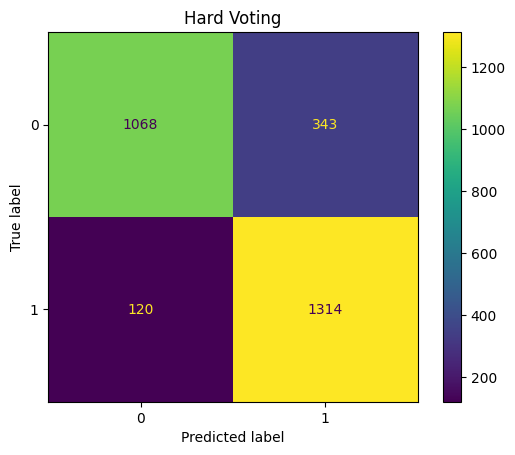

In [ ]:
hard_conf_matrix = confusion_matrix(y_test, y_pred_hard)

hard_matrix_display = ConfusionMatrixDisplay(hard_conf_matrix)

hard_matrix_display.plot()

plt.title("Hard Voting")
plt.show()

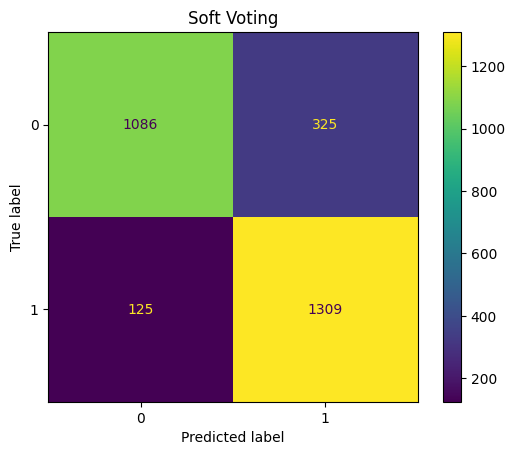

In [ ]:
soft_conf_matrix = confusion_matrix(y_test, y_pred_soft)

soft_matrix_display = ConfusionMatrixDisplay(soft_conf_matrix)

soft_matrix_display.plot()

plt.title("Soft Voting")
plt.show()

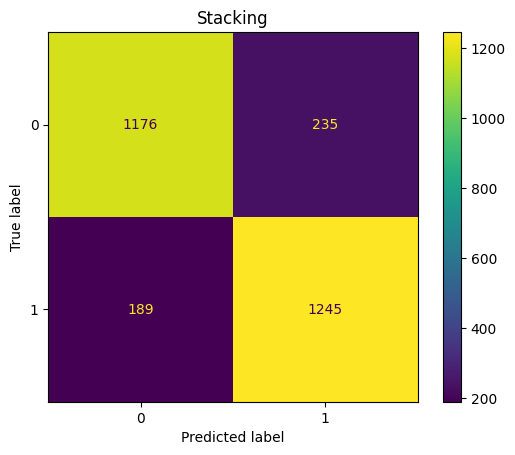

In [ ]:
stacking_conf_matrix = confusion_matrix(y_test, y_pred_stacking)

stacking_matrix_display = ConfusionMatrixDisplay(stacking_conf_matrix)

stacking_matrix_display.plot()

plt.title("Stacking")
plt.show()